In [2]:
using DataFrames, CSV, CategoricalArrays
using Statistics, Clustering, LinearAlgebra
using Plots

In [3]:
filename = "./datasets/Boston.csv"
bhdata = DataFrame(CSV.File(filename))
df = copy(bhdata)
dropmissing!(df)
head(df)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax
,Float64,Float64,Float64,Int64,Float64,Float64,Float64,Float64,Int64,Int64
1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.09,1,296
2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242
3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242
4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222
5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222
6,0.02985,0.0,2.18,0,0.458,6.43,58.7,6.0622,3,222


In [2]:
ndf = names(df)

14-element Vector{String}:
 "crim"
 "zn"
 "indus"
 "chas"
 "nox"
 "rm"
 "age"
 "dis"
 "rad"
 "tax"
 "ptratio"
 "black"
 "lstat"
 "medv"

In [8]:
y = df["medv"]
names_of_x = ["rm", "lstat", "dis"]
X = df[names_of_x]
head(X)

,rm,lstat,dis
,Float64,Float64,Float64
1,6.575,4.98,4.09
2,6.421,9.14,4.9671
3,7.185,4.03,4.9671
4,6.998,2.94,6.0622
5,7.147,5.33,6.0622
6,6.43,5.21,6.0622


In [9]:
names_of_y = ["chas", "rad"]
Z = df[names_of_y]
head(Z)

,chas,rad
,Int64,Int64
1,0,1
2,0,2
3,0,2
4,0,3
5,0,3
6,0,3


# QGPLSIM fitting

In [10]:
include("./src/qgplsim.ji")

Main.qgplsim

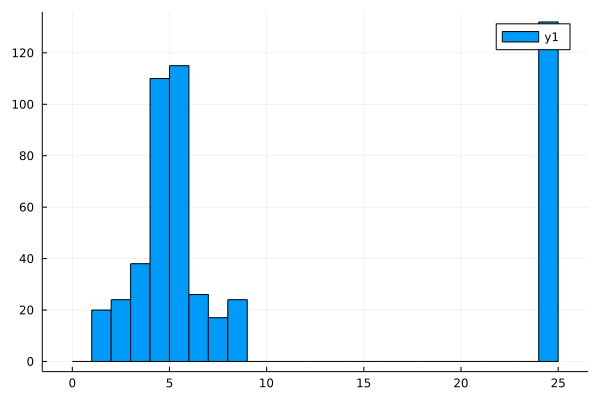

In [31]:
Za = Array(Z)

histogram(Za[:,2], bins = 0:1:25)

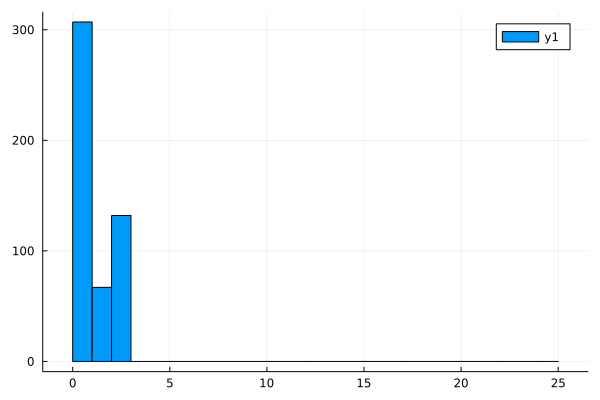

In [32]:
Za[:,2] = (Za[:,2] .> 5) .+ (Za[:,2] .> 8) .+ 0
histogram(Za[:,2], bins = 0:1:25)

506×2 Matrix{Int64}:
 0  0
 0  0
 0  0
 0  0
 0  0
 0  0
 0  0
 0  0
 0  0
 0  0
 0  0
 0  0
 0  0
 ⋮  
 0  0
 0  0
 0  0
 0  0
 0  0
 0  0
 0  0
 0  0
 0  0
 0  0
 0  0
 0  0